In [1]:
library(dplyr)
library(caret)
library(ggplot2)
library(viridis)
library(tidyverse)
library(h2o)
h2o.init()


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice

Loading required package: viridisLite

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:



H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\willk\AppData\Local\Temp\Rtmp4YHeWp\file95d835b522f8/h2o_willk_started_from_r.out
    C:\Users\willk\AppData\Local\Temp\Rtmp4YHeWp\file95d8590b2aac/h2o_willk_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 874 milliseconds 
    H2O cluster timezone:       America/Chicago 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.44.0.3 
    H2O cluster version age:    1 year, 10 months and 26 days 
    H2O cluster name:           H2O_started_from_R_willk_mrt423 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   7.94 GB 
    H2O cluster total cores:    24 
    H2O cluster allowed cores:  24 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:  

Warning message in h2o.clusterInfo():
"
Your H2O cluster version is (1 year, 10 months and 26 days) old. There may be a newer version available.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html"


In [2]:
df <- read.csv("full_clean_data.csv")
df <- df %>% 
  group_by(game_id, play_id) %>% 
  mutate(final_frame = ifelse(max(frame_id) == frame_id, 1, 0))

In [3]:
df_filtered <- df %>%
  drop_na(dist_to_ball_land, speed, accel, direction, accel_direction, optimal_angle, angle_diff)

df_filtered <- df_filtered %>%
  group_by(game_id, play_id, nfl_id) %>%
  mutate(reached_ball = ifelse(dist_to_ball_land < 1.5, 1, 0)) %>% 
  mutate(reached_ball = ifelse(any(final_frame == 1 & reached_ball == 1), 1, 0)) %>%
  ungroup()

In [24]:
df_model <- df_filtered %>%
  mutate(
    nfl_id = as.factor(nfl_id),
    reached_ball = as.factor(reached_ball)
  ) %>%
  select(dist_to_ball_land, speed, accel, angle_diff, time_left_s, nfl_id, reached_ball)


set.seed(123)
train_idx <- sample(1:nrow(df_model), 0.8 * nrow(df_model))
train <- df_model[train_idx, ]
test  <- df_model[-train_idx, ]


train_h2o <- as.h2o(train)
test_h2o  <- as.h2o(test)


features <- c("dist_to_ball_land", "speed", "accel", "angle_diff", "time_left_s", "nfl_id")
target   <- "reached_ball"

model <- h2o.deeplearning(
  x = features,
  y = target,
  training_frame = train_h2o,
  hidden = c(64, 32),
  epochs = 30,
  activation = "Rectifier",
  categorical_encoding = "OneHotInternal",
  stopping_metric = "AUC",
  seed = 123
)

perf <- h2o.performance(model, newdata = test_h2o)
h2o.auc(perf)
h2o.confusionMatrix(perf)


pred <- h2o.predict(model, test_h2o)
pred_probs <- as.vector(pred$p1)
pred_class <- as.vector(pred$predict)




  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


[1] 0.996083

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,84794,2100,0.02416738,=2100/86894
1,1064,24630,0.04141045,=1064/25694
Totals,85858,26730,0.02810246,=3164/112588


  |======================================================================| 100%


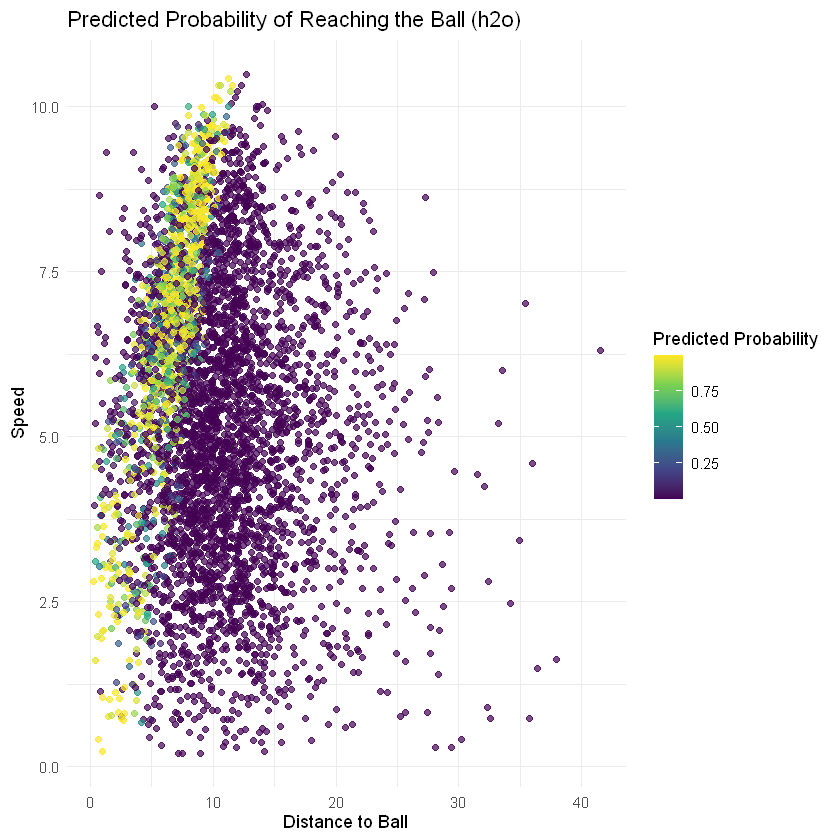

In [5]:
plot_df <- as.data.frame(test_h2o) %>%
  mutate(pred_prob = pred_probs)

ggplot(plot_df |> filter(time_left_s == 1), aes(x = dist_to_ball_land, y = speed, color = pred_prob)) +
  geom_point(alpha = 0.7) +
  scale_color_viridis_c() +
  labs(
    title = "Predicted Probability of Reaching the Ball (h2o)",
    x = "Distance to Ball",
    y = "Speed",
    color = "Predicted Probability"
  ) +
  theme_minimal()

In [25]:
model_no_id <- h2o.deeplearning(
  x = c("dist_to_ball_land", "speed", "accel", "angle_diff", "time_left_s"),
  y = target,
  training_frame = train_h2o,
  hidden = c(64, 32),
  epochs = 30,
  activation = "Rectifier",
  stopping_metric = "AUC",
  seed = 123
)

  |======================================================================| 100%


In [26]:
perf2 <- h2o.performance(model_no_id, newdata = test_h2o)
h2o.auc(perf2)
h2o.confusionMatrix(perf2)


pred2 <- h2o.predict(model_no_id, test_h2o)
pred_probs2 <- as.vector(pred2$p1)
pred_class2 <- as.vector(pred2$predict)

plot_df <- plot_df %>% 
  mutate(prob2 = pred_probs2) %>% 
  mutate(effect = pred_prob - prob2)
  

[1] 0.9915579

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,83472,3422,0.03938132,=3422/86894
1,1617,24077,0.06293298,=1617/25694
Totals,85089,27499,0.04475610,=5039/112588


  |======================================================================| 100%


In [31]:
library(nflreadr)
players <- load_players()

In [32]:
plot_df <- plot_df %>% 
  left_join(players %>% 
              select(nfl_id, display_name, pff_position), by = c("nfl_id"))


In [34]:
plot_df %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  filter(n > 50) %>% 
  arrange(desc(avg)) %>%
  head()

nfl_id,name,n,avg,total,pos
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
54694,Bo Melton,64,0.10677,6.83304,WR
44978,Jamal Agnew,55,0.09100,5.00480,WR
54603,Calvin Austin III,73,0.07494,5.47066,WR
55928,Marvin Mims Jr.,93,0.06921,6.43662,WR
52518,Darnay Holmes,52,0.06746,3.50797,CB
54600,Joshua Williams,121,0.06026,7.29086,CB


In [35]:
varimp <- h2o.varimp(model)
varimp

variable,relative_importance,scaled_importance,percentage
<chr>,<dbl>,<dbl>,<dbl>
dist_to_ball_land,1.0000000,1.0000000,0.011315674
time_left_s,0.6316934,0.6316934,0.007148037
angle_diff,0.4620061,0.4620061,0.005227910
speed,0.3586332,0.3586332,0.004058176
nfl_id.45004,0.1989352,0.1989352,0.002251086
nfl_id.46095,0.1817414,0.1817414,0.002056527
nfl_id.41282,0.1763536,0.1763536,0.001995560
nfl_id.52417,0.1733509,0.1733509,0.001961582
nfl_id.54476,0.1730086,0.1730086,0.001957709


In [36]:
perf3 <- h2o.performance(model, newdata = as.h2o(df_filtered))
h2o.auc(perf3)
h2o.confusionMatrix(perf3)


pred3 <- h2o.predict(model, as.h2o(df_filtered))
pred_probs3 <- as.vector(pred3$p1)
pred_class3 <- as.vector(pred3$predict)

  |======================================================================| 100%


[1] 0.997303

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,426369,7117,0.01641806,=7117/433486
1,5879,123571,0.04541522,=5879/129450
Totals,432248,130688,0.02308611,=12996/562936


  |======================================================================| 100%
  |======================================================================| 100%


In [37]:
perf4 <- h2o.performance(model_no_id, newdata = as.h2o(df_filtered))
h2o.auc(perf4)
h2o.confusionMatrix(perf4)


pred4 <- h2o.predict(model_no_id, as.h2o(df_filtered))
pred_probs4 <- as.vector(pred4$p1)
pred_class4 <- as.vector(pred4$predict)


  |======================================================================| 100%


[1] 0.9914348

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,417297,16189,0.03734607,=16189/433486
1,8965,120485,0.06925454,=8965/129450
Totals,426262,136674,0.04468359,=25154/562936


  |======================================================================| 100%
  |======================================================================| 100%


In [38]:
data <- df_filtered %>% 
  mutate(pred1 = pred_probs3, pred2 = pred_probs4, effect = pred1 - pred2) %>% 
  left_join(players %>% mutate(nfl_id = as.numeric(nfl_id)) %>% select(nfl_id, display_name, pff_position), by = c("nfl_id"))


In [39]:
data %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  #filter(n > 50, pos != "WR", pos != "TE", pos != "HB") %>% 
  filter(n > 50, pos == "CB") %>% 
  arrange(desc(total)) %>%
  head(10)

nfl_id,name,n,avg,total,pos
<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
43700,Jonathan Jones,1321,0.05464,72.17973,CB
56353,Starling Thomas V,701,0.09947,69.72946,CB
39984,Darius Slay,1742,0.03914,68.19043,CB
42441,Steven Nelson,1742,0.03543,61.72102,CB
46456,Darious Williams,1917,0.02747,52.66749,CB
53601,Deommodore Lenoir,1671,0.02808,46.92877,CB
44893,Fabian Moreau,1680,0.02772,46.57411,CB
43986,Antonio Hamilton,877,0.05031,44.11936,CB
56097,Carrington Valentine,1151,0.03763,43.31602,CB


In [40]:
data %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  #filter(n > 50, pos != "WR", pos != "TE", pos != "HB") %>% 
  filter(n > 50, pos == "WR") %>% 
  arrange(desc(total)) %>%
  head(10)

nfl_id,name,n,avg,total,pos
<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
52433,Brandon Aiyuk,1298,0.07590,98.51442,WR
43454,Tyreek Hill,1792,0.05169,92.62005,WR
53541,Amon-Ra St. Brown,1496,0.05617,84.02476,WR
53434,Ja'Marr Chase,1383,0.05542,76.64764,WR
46095,Calvin Ridley,1603,0.04633,74.26100,WR
41282,Davante Adams,1851,0.03627,67.14075,WR
52441,Tee Higgins,885,0.07511,66.47557,WR
54597,Romeo Doubs,1160,0.05712,66.26037,WR
41246,Brandin Cooks,901,0.06618,59.62580,WR


In [41]:
data %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  #filter(n > 50, pos != "WR", pos != "TE", pos != "HB") %>% 
  filter(n > 50, pos == "S") %>% 
  arrange(desc(total)) %>%
  head(10)

nfl_id,name,n,avg,total,pos
<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
55910,Brian Branch,1683,0.02424,40.79697,S
46137,Justin Reid,1506,0.02681,40.37488,S
53604,Jason Pinnock,1351,0.02821,38.11738,S
55931,Sydney Brown,643,0.05839,37.54399,S
43351,James Bradberry,2175,0.01714,37.27614,S
52607,Jordan Fuller,2051,0.01763,36.15766,S
47899,Amani Hooker,1521,0.02278,34.64967,S
54808,Reed Blankenship,1724,0.01858,32.02349,S
43387,Justin Simmons,1633,0.01865,30.45904,S


In [74]:
top10_by_pos <- function(df, position) {
  df = df %>%
    group_by(nfl_id) %>%
    summarise(
      name  = unique(display_name),
      n     = n(),
      avg   = round(mean(effect), 5),
      total = round(sum(effect), 5),
      pos   = unique(pff_position),
      .groups = "drop"
    ) %>%
    filter(n > 50, pos == position) %>%
    arrange(desc(total)) %>%
    slice_head(n = 10)

  gt_table <- df %>%
    arrange(pos, desc(total)) %>%
    select(pos, name, avg) %>%
    gt() %>%
      cols_label(
        name = "Name",
        avg  = "Average Effect"
      ) %>%
      fmt_number(columns = avg, decimals = 5) 

  gtsave(
    gt_table,
      filename = paste0(position, "_table.png"),
      vwidth = 1200,
      vheight = 2000
    )
  }

top10_by_pos(data, "CB")
top10_by_pos(data, "WR")
top10_by_pos(data, "S")


In [60]:
install.packages("webshot")

webshot::install_phantomjs()


Installing package into 'C:/Users/willk/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'webshot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\willk\AppData\Local\Temp\Rtmp4YHeWp\downloaded_packages


Registered S3 method overwritten by 'webshot':
  method        from    
  print.webshot webshot2

Warning message in utils::download.file(url, method = method, ...):
"the 'wininet' method is deprecated for http:// and https:// URLs"
phantomjs has been installed to C:\Users\willk\AppData\Roaming\PhantomJS



In [66]:
library(gt)

gt_table <- combined %>%
  select(pos, name, avg) %>%
  arrange(pos, desc(avg)) %>%
  gt(groupname_col = "pos") %>%
  cols_label(
    name = "Name",
    avg  = "Average Effect"
  ) %>%
  fmt_number(columns = avg, decimals = 5) 

gtsave(
  gt_table,
  filename = "combined_table.png",
  vwidth = 1200,
  vheight = 2000
)



In [16]:
plays <- data %>%
  group_by(game_id, play_id, nfl_id, display_name, pff_position) %>%
  summarise(
    start_prob1 = pred1[frame_id == min(frame_id)],   # probability at first frame
    end_prob1   = pred1[frame_id == max(frame_id)],   # probability at last frame
    start_prob2 = pred2[frame_id == min(frame_id)],   # probability at first frame
    end_prob2   = pred2[frame_id == max(frame_id)],   # probability at last frame
    n_frames   = n(),
    .groups = "drop"
  ) %>% 
  mutate(change1 = end_prob1 - start_prob1, change2 = end_prob2 - start_prob2)


In [17]:
plays %>% 
  group_by(nfl_id) %>% 
  summarise(n = n(),
            avg1 = mean(change1), 
            avg2 = mean(change2), 
            total1 = sum(change1),
            total2 = sum(change2),
            effect_avg = avg1 - avg2,
            effect_tot = total1 - total2
            ) %>% 
  left_join(players %>% mutate(nfl_id = as.numeric(nfl_id)) %>% select(nfl_id, display_name, pff_position), by = c("nfl_id")) %>% 
  select(nfl_id, display_name, everything()) %>% 
  filter(n > 50) %>% 
  arrange(desc(effect_avg))

nfl_id,display_name,n,avg1,avg2,total1,total2,effect_avg,effect_tot,pff_position
<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
52584,K.J. Osborn,64,0.119211753,-0.103572564,7.6295522,-6.6286441,0.22278432,14.258196,WR
52536,Gabe Davis,69,0.073021761,-0.116151553,5.0385015,-8.0144571,0.18917331,13.052959,WR
41233,Mike Evans,120,0.058463928,-0.108054635,7.0156714,-12.9665562,0.16651856,19.982228,WR
55885,Quentin Johnston,54,0.152884327,-0.006149425,8.2557537,-0.3320690,0.15903375,8.587823,WR
55934,Tank Dell,70,0.170127659,0.026401607,11.9089362,1.8481125,0.14372605,10.060824,WR
55887,Jordan Addison,94,0.100471174,-0.041112376,9.4442904,-3.8645633,0.14158355,13.308854,WR
44849,Zay Jones,55,0.113354969,-0.023876898,6.2345233,-1.3132294,0.13723187,7.547753,WR
52442,Michael Pittman,121,0.055596744,-0.071296787,6.7272060,-8.6269113,0.12689353,15.354117,WR
53456,Rashod Bateman,53,0.096452166,-0.026934203,5.1119648,-1.4275127,0.12338637,6.539478,WR


  |======================================================================| 100%
  |======================================================================| 100%


Warning message:
"Removed 38 rows containing missing values or values outside the scale range
(`geom_tile()`)."


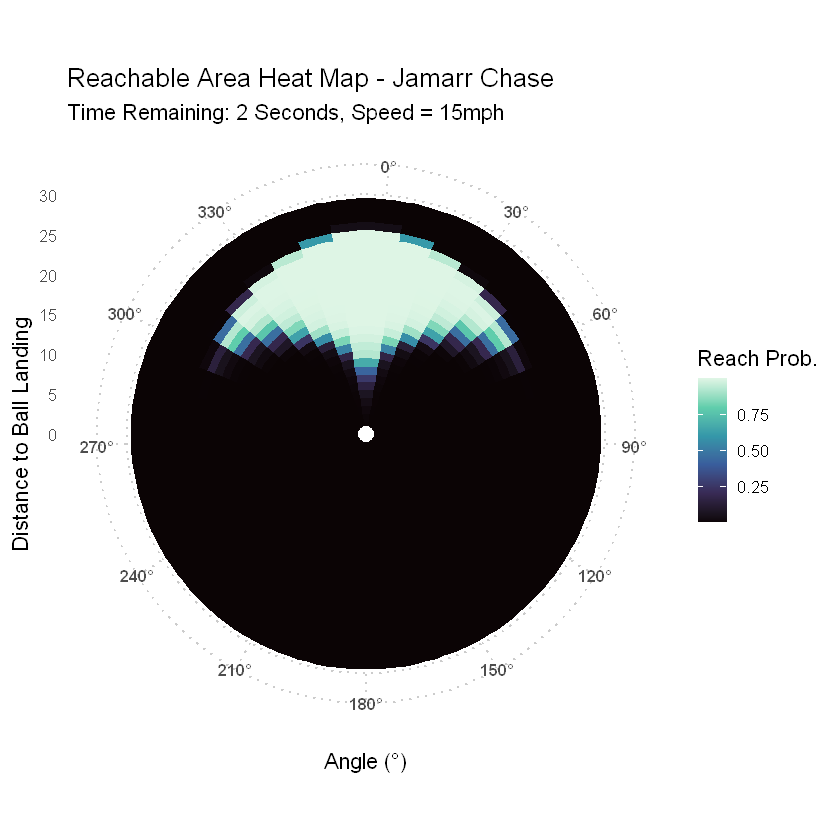

In [81]:
test_df <- expand.grid(
  nfl_id = 53434, # 54508 for wandale robinson, 44881 for cooper kupp, 53434 jamarr chase
  dist_to_ball_land = seq(1, 30),
  time_left_s = 2,
  angle_diff = seq(0, 180, 10),
  speed = 15, 
  accel = 0
)

test_pred <- h2o.predict(model, as.h2o(test_df))
test_probs <- as.vector(test_pred$p1)

test_df <- test_df %>% 
  mutate(pred = test_probs)

# Mirror your 0–180° data to make a full 0–360° field
test_df_mirrored <- test_df %>%
  mutate(angle_diff_mirror = angle_diff) %>%
  bind_rows(
    test_df %>%
      mutate(angle_diff_mirror = 360 - angle_diff)
  ) %>% 
  mutate(reach = pred > .5)

# Plot: 0° straight up, increasing clockwise
ggplot(test_df_mirrored, aes(x = angle_diff_mirror, y = dist_to_ball_land, fill = pred)) +
  geom_tile() +
  coord_polar(start = 0, direction = 1) +  # ✅ This combination puts 0° at top and increases clockwise
  scale_fill_viridis_c(option = "mako", name = "Reach Prob.") +
  scale_x_continuous(
    breaks = seq(0, 330, 30),
    labels = paste0(seq(0, 330, 30), "°")
  ) +
  scale_y_continuous(
    limits = c(0,30),
    breaks = seq(0, 30, 5),
    name = "Distance to Ball Landing"
  ) +
  labs(
    title = "Reachable Area Heat Map - Jamarr Chase",
    subtitle = paste("Time Remaining:", test_df_mirrored$time_left_s, "Seconds, Speed = 15mph"),
    x = "Angle (°)",
    y = "Distance"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = "gray80", linetype = "dotted"),
    #plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(size = 10, face = "bold"),
    legend.position = "right"
  ) +
  # Optional: show the player in the center
  annotate("point", x = 0, y = 0, size = 4, color = "white")


In [20]:
extra_data <- data %>% 
  select(game_id, play_id, frame_id, x, y, 15:28)


In [21]:
head(extra_data)

game_id,play_id,frame_id,x,y,time_left_s,dist_to_ball_land,speed,direction,accel,accel_direction,optimal_angle,angle_diff,final_frame,reached_ball,pred1,pred2,effect,display_name
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2023090700,101,1,53.20,13.98,2.0,17.40240,7.864477,-11.73857,-0.35522904,-46.33304,-54.68431,42.94574,0,0,2.330520e-05,0.0801717283,-0.0801484231,Josh Reynolds
2023090700,101,2,53.96,13.78,1.9,16.80744,7.858753,-14.74356,-0.05724015,-104.03624,-56.40448,41.66092,0,0,4.230782e-06,0.0483391804,-0.0483349496,Josh Reynolds
2023090700,101,3,54.70,13.54,1.8,16.20528,7.779460,-17.96914,-0.79292946,-116.56505,-58.11455,40.14541,0,0,6.183334e-07,0.0121974571,-0.0121968388,Josh Reynolds
2023090700,101,4,55.41,13.27,1.7,15.60777,7.596052,-20.82089,-1.83408530,-135.00000,-59.80434,38.98345,0,0,3.585680e-09,0.0006464161,-0.0006464125,Josh Reynolds
2023090700,101,5,56.09,12.95,1.6,14.99526,7.515318,-25.20112,-0.80733915,-120.96376,-61.43529,36.23416,0,0,4.965977e-09,0.0006920592,-0.0006920542,Josh Reynolds
2023090700,101,6,56.73,12.58,1.5,14.36944,7.392564,-30.03328,-1.22753860,-128.65981,-62.97132,32.93804,0,0,3.967796e-10,0.0001347727,-0.0001347723,Josh Reynolds


In [22]:
rm(tracking_df)

Warning message in rm(tracking_df):
"object 'tracking_df' not found"


In [23]:
tracking_df <- read_csv("play_animation/data/tracking_df.csv")
head(tracking_df)

ERROR: Error: 'play_animation/data/tracking_df.csv' does not exist in current working directory ('d:/github/will/BDB').


In [ ]:
tracking_df <- tracking_df %>% left_join(extra_data, by = c("game_id", "play_id", "frame_id", "x", "y")) %>% 
  mutate(pred1 = round(pred1, 3),
         pred2 = round(pred2, 3))

In [ ]:
dim(tracking_df)

[1] 5443515      39